# MNIST 99% with CNN

Input > Conv > Pool > Conv > Pool > FC > 0~9

In [ ]:
# Lab 11 MNIST and Convolutional Neural Network
import tensorflow as tf
import random
# import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

tf.set_random_seed(777)  # reproducibility

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
# Check out https://www.tensorflow.org/get_started/mnist/beginners for
# more information about the mnist dataset

# hyper parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

# input place holders
X = tf.placeholder(tf.float32, [None, 784])
X_img = tf.reshape(X, [-1, 28, 28, 1])   # img 28x28x1 (black/white)
Y = tf.placeholder(tf.float32, [None, 10])

# L1 ImgIn shape=(?, 28, 28, 1)
W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01)) #Shape가 왜 이렇게 정의되는지 이해 못하였음 > 텐서 곱 관련한 개념이 부족한듯
#    Conv     -> (?, 28, 28, 32)
#    Pool     -> (?, 14, 14, 32)
L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1], #pooling에서 필터의 크기는 ksize 옵션을 이용(kernal size)
                    strides=[1, 2, 2, 1], padding='SAME') #stride는 정수가 아니라 텐서다
'''
Tensor("Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
'''

# L2 ImgIn shape=(?, 14, 14, 32)
W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
#    Conv      ->(?, 14, 14, 64)
#    Pool      ->(?, 7, 7, 64)
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1], 
                    strides=[1, 2, 2, 1], padding='SAME')
L2_flat = tf.reshape(L2, [-1, 7 * 7 * 64])
'''
Tensor("Conv2D_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 3136), dtype=float32)
'''

#1 Layer짜리 Softmax Classification 구현
# Final FC 7x7x64 inputs -> 10 outputs
W3 = tf.get_variable("W3", shape=[7 * 7 * 64, 10],
                     initializer=tf.contrib.layers.xavier_initializer())
b = tf.Variable(tf.random_normal([10]))
logits = tf.matmul(L2_flat, W3) + b

# define cost/loss & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch_xs, Y: batch_ys}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

# Test model and check accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy:', sess.run(accuracy, feed_dict={
      X: mnist.test.images, Y: mnist.test.labels}))

# Get one and predict
r = random.randint(0, mnist.test.num_examples - 1)
print("Label: ", sess.run(tf.argmax(mnist.test.labels[r:r + 1], 1)))
print("Prediction: ", sess.run(
    tf.argmax(logits, 1), feed_dict={X: mnist.test.images[r:r + 1]}))

# plt.imshow(mnist.test.images[r:r + 1].
#           reshape(28, 28), cmap='Greys', interpolation='nearest')
# plt.show()

'''
Epoch: 0001 cost = 0.340291267
Epoch: 0002 cost = 0.090731326
Epoch: 0003 cost = 0.064477619
Epoch: 0004 cost = 0.050683064
Epoch: 0005 cost = 0.041864835
Epoch: 0006 cost = 0.035760704
Epoch: 0007 cost = 0.030572132
Epoch: 0008 cost = 0.026207981
Epoch: 0009 cost = 0.022622454
Epoch: 0010 cost = 0.019055919
Epoch: 0011 cost = 0.017758641
Epoch: 0012 cost = 0.014156652
Epoch: 0013 cost = 0.012397016
Epoch: 0014 cost = 0.010693789
Epoch: 0015 cost = 0.009469977
Learning Finished!
Accuracy: 0.9885
'''


# 결론
ConvNN으로 FC가 1층인데도 정확도가 98.85%에 달하고 있다.
---

# Deep CNN
Extraction Layer와 FC Layer의 깊이를 늘린 형태

In [1]:
# Lab 11 MNIST and Deep learning CNN
# Lab 10 MNIST and Dropout
import tensorflow as tf
import random
import matplotlib.pyplot as plt

tf.set_random_seed(777)  # reproducibility

#from tensorflow.examples.tutorials.mnist import input_data

# Check out https://www.tensorflow.org/get_started/mnist/beginners for
# more information about the mnist dataset
#mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

#버전 문제로, 1.15.5버전에서는 아래를 실행 (1.1 이상에서 호환)
mnist=tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

import numpy as np
x_train = np.reshape(x_train, (len(x_train),784))
x_test = np.reshape(x_test, (len(x_test),784))
#y_train = tf.one_hot(y_train, depth=10, axis=-1)
y_train = np.eye(10)[y_train] #https://stackoverflow.com/questions/38592324/one-hot-encoding-using-numpy
y_test = np.eye(10)[y_test]


# hyper parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

# dropout (keep_prob) rate  0.7~0.5 on training, but should be 1 for testing
keep_prob = tf.placeholder(tf.float32)

# input place holders
X = tf.placeholder(tf.float32, [None, 784])
X_img = tf.reshape(X, [-1, 28, 28, 1])   # img 28x28x1 (black/white)
Y = tf.placeholder(tf.float32, [None, 10])

# L1 ImgIn shape=(?, 28, 28, 1)
W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))
#    Conv     -> (?, 28, 28, 32)
#    Pool     -> (?, 14, 14, 32)
L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1],
                    strides=[1, 2, 2, 1], padding='SAME')
L1 = tf.nn.dropout(L1, keep_prob=keep_prob) #학습 효율을 위해 Dropout 추가
'''
Tensor("Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
Tensor("dropout/mul:0", shape=(?, 14, 14, 32), dtype=float32)
'''

# L2 ImgIn shape=(?, 14, 14, 32)
W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
#    Conv      ->(?, 14, 14, 64)
#    Pool      ->(?, 7, 7, 64)
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1],
                    strides=[1, 2, 2, 1], padding='SAME')
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)
'''
Tensor("Conv2D_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
Tensor("dropout_1/mul:0", shape=(?, 7, 7, 64), dtype=float32)
'''

# L3 ImgIn shape=(?, 7, 7, 64)
W3 = tf.Variable(tf.random_normal([3, 3, 64, 128], stddev=0.01))
#    Conv      ->(?, 7, 7, 128)
#    Pool      ->(?, 4, 4, 128)
#    Reshape   ->(?, 4 * 4 * 128) # Flatten them for FC
L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding='SAME')
L3 = tf.nn.relu(L3)
L3 = tf.nn.max_pool(L3, ksize=[1, 2, 2, 1], strides=[
                    1, 2, 2, 1], padding='SAME')
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)
L3_flat = tf.reshape(L3, [-1, 128 * 4 * 4])
'''
Tensor("Conv2D_2:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("Relu_2:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("MaxPool_2:0", shape=(?, 4, 4, 128), dtype=float32)
Tensor("dropout_2/mul:0", shape=(?, 4, 4, 128), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 2048), dtype=float32)
'''

# L4 FC 4x4x128 inputs -> 625 outputs
W4 = tf.get_variable("W4", shape=[128 * 4 * 4, 625],
                     initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([625]))
L4 = tf.nn.relu(tf.matmul(L3_flat, W4) + b4)
L4 = tf.nn.dropout(L4, keep_prob=keep_prob)
'''
Tensor("Relu_3:0", shape=(?, 625), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 625), dtype=float32)
'''

# L5 Final FC 625 inputs -> 10 outputs
W5 = tf.get_variable("W5", shape=[625, 10],
                     initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([10]))
logits = tf.matmul(L4, W5) + b5
'''
Tensor("add_1:0", shape=(?, 10), dtype=float32)
'''

# define cost/loss & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0
    #total_batch = int(mnist.train.num_examples / batch_size)
    total_batch = int(len(x_train) / batch_size)

    for i in range(total_batch):
        #batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        batch_xs, batch_ys = x_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        feed_dict = {X: batch_xs, Y: batch_ys, keep_prob: 0.7}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

# Test model and check accuracy

# if you have a OOM error, please refer to lab-11-X-mnist_deep_cnn_low_memory.py

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy:', sess.run(accuracy, feed_dict={
      #X: mnist.test.images, Y: mnist.test.labels, keep_prob: 1}))
      X: x_test, Y: y_test, keep_prob: 1}))

# Get one and predict
#r = random.randint(0, mnist.test.num_examples - 1)
#print("Label: ", sess.run(tf.argmax(mnist.test.labels[r:r + 1], 1)))
#print("Prediction: ", sess.run(
#    tf.argmax(logits, 1), feed_dict={X: mnist.test.images[r:r + 1], keep_prob: 1}))

# plt.imshow(mnist.test.images[r:r + 1].
#           reshape(28, 28), cmap='Greys', interpolation='nearest')
# plt.show()

'''
Learning stared. It takes sometime.
Epoch: 0001 cost = 0.385748474
Epoch: 0002 cost = 0.092017397
Epoch: 0003 cost = 0.065854684
Epoch: 0004 cost = 0.055604566
Epoch: 0005 cost = 0.045996377
Epoch: 0006 cost = 0.040913645
Epoch: 0007 cost = 0.036924479
Epoch: 0008 cost = 0.032808939
Epoch: 0009 cost = 0.031791007
Epoch: 0010 cost = 0.030224456
Epoch: 0011 cost = 0.026849916
Epoch: 0012 cost = 0.026826763
Epoch: 0013 cost = 0.027188021
Epoch: 0014 cost = 0.023604777
Epoch: 0015 cost = 0.024607201
Learning Finished!
Accuracy: 0.9938
'''
pass

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Learning started. It takes sometime.
Epoch: 0001 cost = 0.433491531
Epoch: 0002 cost = 0.132681115
Epoch: 0003 cost = 0.094609807
Epoch: 0004 cost = 0.074512620
Epoch: 0005 cost = 0.064369959
Epoch: 0006 cost = 0.056653222
Epoch: 0007 cost = 0.050937967
Epoch: 0008 cost = 0.047380891
Epoch: 0009 cost = 0.044411958
Epoch: 0010 co

'\nLearning stared. It takes sometime.\nEpoch: 0001 cost = 0.385748474\nEpoch: 0002 cost = 0.092017397\nEpoch: 0003 cost = 0.065854684\nEpoch: 0004 cost = 0.055604566\nEpoch: 0005 cost = 0.045996377\nEpoch: 0006 cost = 0.040913645\nEpoch: 0007 cost = 0.036924479\nEpoch: 0008 cost = 0.032808939\nEpoch: 0009 cost = 0.031791007\nEpoch: 0010 cost = 0.030224456\nEpoch: 0011 cost = 0.026849916\nEpoch: 0012 cost = 0.026826763\nEpoch: 0013 cost = 0.027188021\nEpoch: 0014 cost = 0.023604777\nEpoch: 0015 cost = 0.024607201\nLearning Finished!\nAccuracy: 0.9938\n'

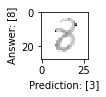

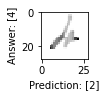

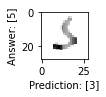

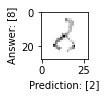

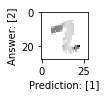

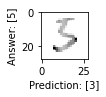

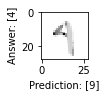

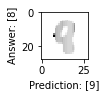

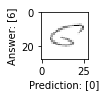

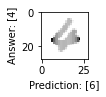

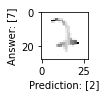

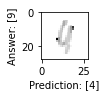

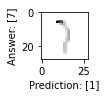

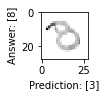

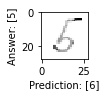

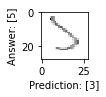

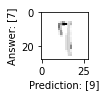

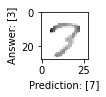

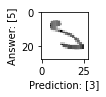

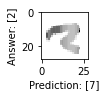

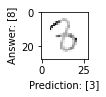

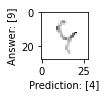

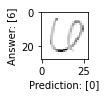

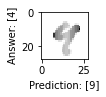

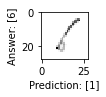

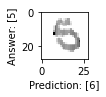

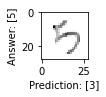

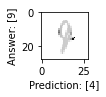

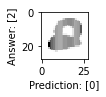

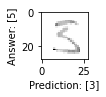

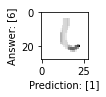

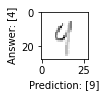

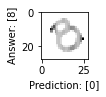

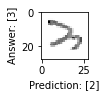

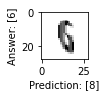

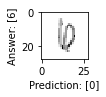

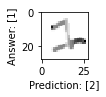

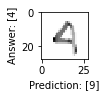

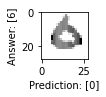

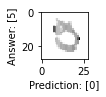

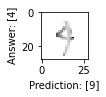

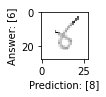

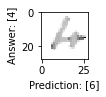

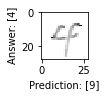

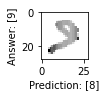

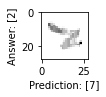

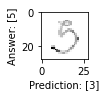

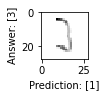

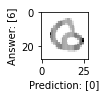

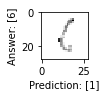

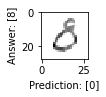

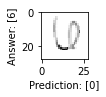

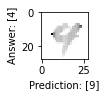

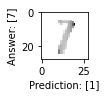

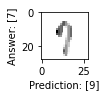

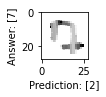

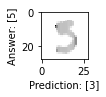

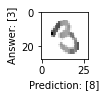

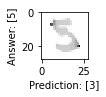

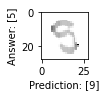

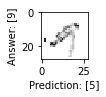

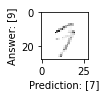

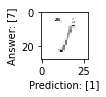

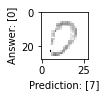

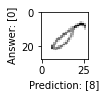

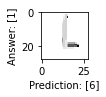

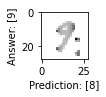

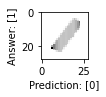

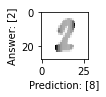

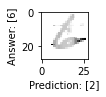

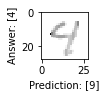

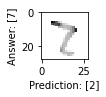

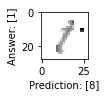

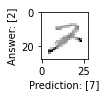

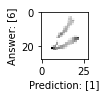

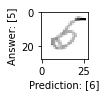

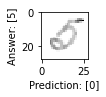

In [3]:
#Finding Wrong answer
#if tf.math.not_equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1)))
from pprint import *
#wrong_prediction=tf.math.not_equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))
wrong_prediction=tf.math.not_equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
wrong_answer=sess.run(wrong_prediction, feed_dict={X:x_test, Y:y_test, keep_prob:1})
j=1
plt.figure(j)
for i in range(len(wrong_answer)):    
    n=1
    if wrong_answer[i]:
        plt.subplot(4,4,n)
        n+=1
        if n==4:
            j+=1
            plt.figure(j)
            n=1
        #print("=====")
        #print("Prediction: ", sess.run(tf.argmax(hypothesis, 1), feed_dict={X:x_test[i:i+1], keep_prob:1}))
        #print("Answer: ", sess.run(tf.argmax(y_test[i:i+1], 1)))
        plt.xlabel("Prediction: "+ str(sess.run(tf.argmax(logits, 1), feed_dict={X:x_test[i:i+1], keep_prob:1})))
        plt.ylabel("Answer: "+ str(sess.run(tf.argmax(y_test[i:i+1], 1))))
        plt.imshow(x_test[i:i+1].reshape(28,28), cmap='Greys', interpolation='nearest')
        plt.show()

# 결론
정확도가 무려 99.38%에 달하고 있다.